In [1]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16, ResNet50
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [2]:
filepath = '../kaggle_room_street_data/house_data'

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # rescale the pixel values to be between 0 and 1
    validation_split=0.2 # 20% of the data will be used for validation
)

In [22]:
# Upload images in the data generator
train_generator = data_generator.flow_from_directory(
    filepath,
    target_size=(224,224), # resize the images to 224x224 which is the input size of the VGG16/ResNet model
    batch_size=128, # number of images to process at a time
    class_mode='categorical', # categorical encoding for the labels 
    subset='training' # use the training subset of the data
)

Found 5961 images belonging to 6 classes.


In [23]:
# Object train_generator is an iterator
train_generator

In [24]:
# This is the shape of the images in the dataset
train_generator.image_shape

(224, 224, 3)

In [25]:
# This is the first image in the training set
train_generator[0][0][0]

array([[[0.69803923, 0.6313726 , 0.5529412 ],
        [0.68235296, 0.6156863 , 0.5372549 ],
        [0.68235296, 0.61960787, 0.5568628 ],
        ...,
        [0.69411767, 0.61960787, 0.56078434],
        [0.6862745 , 0.6156863 , 0.56078434],
        [0.69411767, 0.62352943, 0.5686275 ]],

       [[0.6901961 , 0.62352943, 0.54509807],
        [0.6745098 , 0.60784316, 0.5294118 ],
        [0.67058825, 0.60784316, 0.54509807],
        ...,
        [0.6862745 , 0.6117647 , 0.5529412 ],
        [0.6784314 , 0.60784316, 0.5529412 ],
        [0.6901961 , 0.61960787, 0.5647059 ]],

       [[0.68235296, 0.6156863 , 0.5372549 ],
        [0.6666667 , 0.6       , 0.52156866],
        [0.6666667 , 0.6039216 , 0.5411765 ],
        ...,
        [0.6745098 , 0.6       , 0.5411765 ],
        [0.67058825, 0.6       , 0.54509807],
        [0.68235296, 0.6117647 , 0.5568628 ]],

       ...,

       [[0.6784314 , 0.5921569 , 0.5411765 ],
        [0.6666667 , 0.5803922 , 0.5294118 ],
        [0.6666667 , 0

In [26]:
# Number of batches in the training set (each batch is a tuple of (images, labels))
    # Each batch has 32 images and 32 labels, then 5961 images divided by 32 is 186.28125 then 187 batches
len(train_generator)

47

In [27]:
# Tuple with 2 elements: (images, labels)
len(train_generator[39])

2

In [28]:
# Number of images in the 39th batch
    # 32 images in the 39th batch (as expected)
len(train_generator[39][0])

128

In [29]:
# This is the pixels of the first image in the 39th batch
    # 224x224x3 (224 is the height, 224 is the width, 3 is the number of color channels (RGB))
print(f'The shape of the first image in the 39th batch is: {train_generator[39][0][0].shape}')


The shape of the first image in the 39th batch is: (224, 224, 3)


The shape (224, 224, 3) represents the dimensions of each image in your dataset after preprocessing:

- 224: The height of the image in pixels
- 224: The width of the image in pixels
- 3: The number of color channels (RGB - Red, Green, Blue)

In [30]:
train_generator.class_indices

{'bath': 0, 'bed': 1, 'din': 2, 'garage': 3, 'kitchen': 4, 'living': 5}

The train and validation generator have many "camadas"

- train_generator -> a class that holds all the batches of your dataset (if 64 images and batches of 32, then there are 2 batches here)
- train_generator[batch] -> here we change the batch
- train_generator[batch][0 or 1] -> Tuple where at -> 0: have the batch with the X images inside; 1: have the classes of each image (labels)
- train_generator[batch][0 or 1][image] -> here we can go through all the images in that certain batch (this will display the pixels in the format setup)


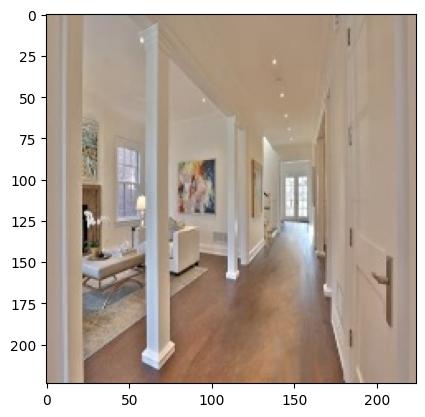

In [31]:
plt.imshow(train_generator[0][0][0])
plt.show()

In [32]:
# THe class of the above image (look into class index to see if correct)
train_generator[0][1][0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [33]:
# The validation gen (the same as the train gen but for validation)
validation_generator = data_generator.flow_from_directory(
    filepath,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 1488 images belonging to 6 classes.


In [34]:
# Models to use (ResNet50 & VGG16)

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3),
    # input_tensor=None,
    # pooling=None,
    # classes=1000,
    # classifier_activation='softmax'
)

base_model_2 = tf.keras.applications.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224,224,3),
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

In [35]:
# Creation of the Neural Network layer by layer 

# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
# ])

base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 classes
])

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    #batch_size=32
)

/Users/armindomatias/.pyenv/versions/rehab_houses/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 454s 10s/step - accuracy: 0.2716 - loss: 1.9044 - val_accuracy: 0.3750 - val_loss: 1.5288
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3910 - loss: 1.5265

KeyboardInterrupt: 